In [1]:
import numpy as np
import pandas as pd

import os
from matplotlib import pyplot as plt

import klampt
from klampt.model import ik

world = klampt.WorldModel()
robot_path = "/home/luca/Klampt-examples/data/robots/robonaut2.rob"
robot_record_dir = "robot_records"
num_ik_solutions = 3000
num_subplots = 5
num_ticks = 5

robot_name = robot_path.split("/")[-1].split(".")[0]
world.loadElement(robot_path)

robot = world.robot(0)
robot.randomizeConfig()
lastLink = robot.link(robot.numLinks()-1)
link = lastLink


num_poses = 3000

# Generate random joint configurations and poses for the robot
joint_configs = []
poses = []
for i in range(num_poses):
    robot.randomizeConfig()
    q = robot.getConfig()
    joint_configs.append(q)
    poses.append(lastLink.getWorldPosition([0,0,0]))

# Create a DataFrame with the joint configurations and poses
df = pd.DataFrame(joint_configs, columns=[i for i in range(robot.numLinks())])
# remove columns with std smaller than 1e-4
df = df.loc[:, df.std() > 1e-3]
num_dofs = df.shape[1]
print(f"Number of DOFs: {num_dofs}")
print(f"Active DOFs: {df.columns}")
active_joints = df.columns.to_numpy(dtype=np.int16)
# print active_joints and the corresponding joint names
for i in active_joints:
    print(f"{i}: {robot.link(int(i)).name}")
    
df.describe()

WorldModel::LoadRobot: /home/luca/Klampt-examples/data/robots/robonaut2.rob
RobParser: Reading robot file /home/luca/Klampt-examples/data/robots/robonaut2.rob...
RobParser:    Parsing robot file, 90 links read...
LoadAssimp: Loaded model /home/luca/Klampt-examples/data/robots/robonaut2/baseplate.off (232 verts, 320 tris)
LoadAssimp: Loaded model /home/luca/Klampt-examples/data/robots/robonaut2/base.off (2052 verts, 3880 tris)
LoadAssimp: Loaded model /home/luca/Klampt-examples/data/robots/robonaut2/waist_center.off (7552 verts, 15072 tris)
LoadAssimp: Loaded model /home/luca/Klampt-examples/data/robots/robonaut2/backpack.off (7108 verts, 14212 tris)
LoadAssimp: Loaded model /home/luca/Klampt-examples/data/robots/robonaut2/body_cover.off (737 verts, 1388 tris)
LoadAssimp: Loaded model /home/luca/Klampt-examples/data/robots/robonaut2/left_shoulder_roll.off (577 verts, 1150 tris)
LoadAssimp: Loaded model /home/luca/Klampt-examples/data/robots/robonaut2/left_shoulder_pitch.off (251 verts, 

,4,9,10,11,12,13,14,15,17,18,...,63,64,65,67,69,70,71,73,74,75
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.045332,0.009412,-0.755961,-2.824035,-1.429583,1.613100,-0.013971,0.005719,-0.004210,0.784709,...,1.478508,1.463863,1.478629,0.606333,0.697952,0.612354,0.505176,-0.273117,-0.018190,-0.260142
std,1.817891,0.909934,0.527546,1.646480,0.829912,1.625572,0.708013,0.449614,0.202115,0.451461,...,0.858618,0.848307,0.865629,0.353585,0.404903,0.355074,0.607921,0.252268,0.701886,0.250893
min,-3.134869,-1.569691,-1.658957,-5.679990,-2.876211,-1.297471,-1.219744,-0.784832,-0.348958,0.000277,...,0.000172,0.000039,0.001123,0.000032,0.000343,0.000461,-0.521995,-0.699792,-1.219476,-0.699625
25%,-1.548871,-0.771000,-1.203193,-4.267606,-2.149292,0.276109,-0.627769,-0.370296,-0.177081,0.387608,...,0.727172,0.732872,0.715882,0.297421,0.349610,0.307924,-0.018560,-0.493667,-0.634037,-0.474307
50%,0.069976,0.013720,-0.766498,-2.831018,-1.424070,1.604525,-0.019705,0.008575,-0.007088,0.783539,...,1.469384,1.463907,1.478356,0.611305,0.688973,0.605081,0.497134,-0.275606,-0.028748,-0.258159
75%,1.629603,0.804417,-0.310165,-1.396461,-0.705098,2.976222,0.612073,0.384315,0.172268,1.170556,...,2.222905,2.183973,2.239628,0.906519,1.054911,0.930376,1.035471,-0.058884,0.588000,-0.043837
max,3.136558,1.569621,0.174979,-0.000455,-0.000268,4.444409,1.218982,0.783640,0.349023,1.569303,...,2.965433,2.966444,2.967081,1.221491,1.395905,1.221538,1.569543,0.174625,1.219602,0.174633


In [2]:

robot_name = robot_path.split("/")[-1].split(".")[0]
world.loadElement(robot_path)

robot = world.robot(0)
robot.randomizeConfig()
lastLink = robot.link(robot.numLinks()-1)
link = lastLink
print(robot.getConfig())
R = link.getTransform()[0]
t = link.getTransform()[1]
obj = ik.objective(link, R=R, t=t)


ik_solutions = np.zeros((num_ik_solutions, robot.numLinks()))

i = 0
while i < num_ik_solutions:
    solved = ik.solve_global(
        obj,
        iters=1000,
        tol=1e-3,
        activeDofs=None,
        numRestarts=100,
        feasibilityCheck=None,
        startRandom=True,
    )
    if solved:
        ik_solutions[i] = robot.getConfig()
        i += 1
        
df = pd.DataFrame(ik_solutions)

# remove columns with std smaller than 1e-4
df = df.loc[:, df.std() > 1e-4]
num_dofs = df.shape[1]
print(f"Number of DOFs: {num_dofs}")
print(f"Active DOFs: {df.columns}")
active_joints = df.columns.to_numpy()
df.describe()

WorldModel::LoadRobot: /home/luca/Klampt-examples/data/robots/robonaut2.rob
[0.0, 0.0, 0.0, 0.0, -1.8778269378737673, 0.0, 0.0, 0.0, 0.0, -1.1633512933335042, -0.4948932704701521, -2.4335996803052717, -0.7761814757842482, 2.7539301533968796, -0.4149269451736133, -0.1261420161887734, 0.0, 0.1822490675179051, 0.751246870058238, 0.9145833632278179, 0.08658721869186835, 0.0, 2.1356983039337667, 1.880451930243639, 0.9605250960182515, 0.0, 0.22423614217002702, 0.023704383384298713, 0.40167855545956577, 0.09766858897994672, 0.0, 0.5020643037063369, 1.8241063288252364, 1.7308923093505166, 0.0, -0.03878977954051921, 0.0, 1.0236038875736315, 0.6166300921742944, 1.0325863319673512, 0.0, 1.0337184350675523, 0.046237079736886955, 4.642106171367739, -1.0250699107419092, -4.415888878091187, -1.173700393491285, 0.4289361858805344, 0.0, 0.09834678833151556, 0.9271236229860801, 0.7903682612769157, 0.5430456479885828, 0.0, 2.7311341740708492, 2.738852989789961, 0.3172303757225305, 0.0, -0.070536517575958

MomentRotation::setMatrix(): Warning- trace of matrix is greater than 3
  Matrix:1 -7.53531e-05 -0.000263687
7.53746e-05 1 9.18726e-05
0.00026368 -9.18956e-05 1

MomentRotation::setMatrix(): Warning- trace of matrix is greater than 3
  Matrix:1 -7.53531e-05 -0.000263687
7.53746e-05 1 9.18726e-05
0.00026368 -9.18956e-05 1

MomentRotation::setMatrix(): Warning- trace of matrix is greater than 3
  Matrix:1 7.24153e-05 -0.000263438
-7.23937e-05 1 9.19106e-05
0.000263445 -9.18947e-05 1

MomentRotation::setMatrix(): Warning- trace of matrix is greater than 3
  Matrix:1 7.24153e-05 -0.000263438
-7.23937e-05 1 9.19106e-05
0.000263445 -9.18947e-05 1

MomentRotation::setMatrix(): Warning- trace of matrix is greater than 3
  Matrix:1 6.05321e-05 -0.000263458
-6.05105e-05 1 9.19075e-05
0.000263464 -9.18948e-05 1

MomentRotation::setMatrix(): Warning- trace of matrix is greater than 3
  Matrix:1 6.05321e-05 -0.000263458
-6.05105e-05 1 9.19075e-05
0.000263464 -9.18948e-05 1

MomentRotation::setMatri

KeyboardInterrupt: 

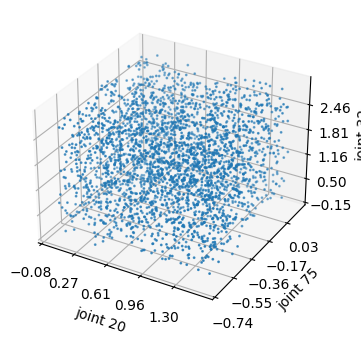

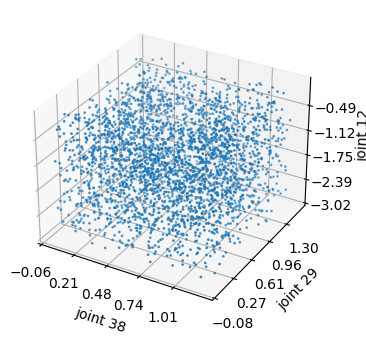

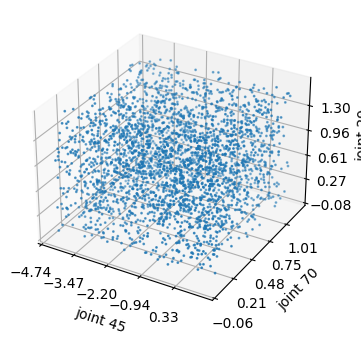

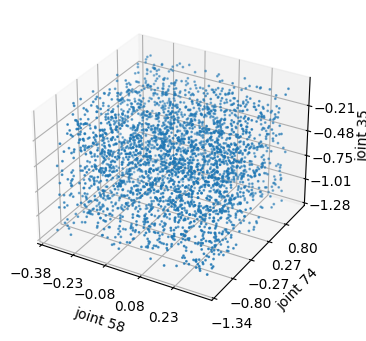

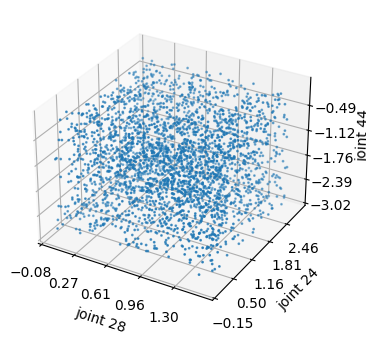

In [3]:
# generate num_subplots times random joint idx at once
subplot_columns = np.array([np.random.choice(df.columns, 3, replace=False) for _ in range(num_subplots)])

def scatter_3d(df, robot_name, num_subplots, subplot_columns):
    # generate 3 times random visualization
    for i in range(num_subplots):
        fig = plt.figure(figsize=(4, 5))
        
        # random pick up 3 columns and sort them 
        columns = subplot_columns[i]

        ax = fig.add_subplot(projection='3d')

        # plot data points by axis = these 3 columns
        ax.scatter(df[columns[0]], df[columns[1]], df[columns[2]], s=1)

        # set labels
        ax.set_xlabel(f"joint {columns[0]}")
        ax.set_ylabel(f"joint {columns[1]}")
        ax.set_zlabel(f"joint {columns[2]}")
        
        num_digits = 2
        start, end = ax.get_xlim()
        step = (end - start) / num_ticks
        ax.xaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))

        start, end = ax.get_ylim()
        step = (end - start) / num_ticks
        ax.yaxis.set_ticks(np.round(np.arange(start, end, step),num_digits))
        
        start, end = ax.get_zlim()
        step = (end - start) / num_ticks
        ax.zaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))
        
        # if not exist, create directory
        if not os.path.exists(f"{robot_record_dir}/{robot_name}"):
            os.makedirs(f"{robot_record_dir}/{robot_name}")
        
        # save figure by robot name and random number
        fig.savefig(f"{robot_record_dir}/{robot_name}/scatter_{i}.png")
    
scatter_3d(df, robot_name, num_subplots, subplot_columns)

In [4]:
from hnne import HNNE

# hnne = HNNE()
# projection = hnne.fit_transform(df.values)
# partitions = np.array(hnne.hierarchy_parameters.partitions)
# partition_sizes = np.array(hnne.hierarchy_parameters.partition_sizes)

# # choose the partition with the size closest to 20
# partition_index = np.argmin(np.abs(partition_sizes - 20))
# partition = partitions[:, partition_index]
# # generate 3 time random visualization with data points colored by partition
# # and assign a color to each partition
# colors = np.random.rand(partition.max() + 1, 3)

def scatter_3d_partition(df, robot_name, num_subplots, partition, subplot_columns, colors):

    for i in range(num_subplots):
        fig = plt.figure(figsize=(4, 5))
        
        columns = subplot_columns[i]

        ax = fig.add_subplot(projection='3d')
        
        for p in partition:
            mask = partition == p
            ax.scatter(
                df.loc[mask, columns[0]],
                df.loc[mask, columns[1]],
                df.loc[mask, columns[2]],
                s=1,
                color=colors[p],
            )

        ax.set_xlabel(f"joint {columns[0]}")
        ax.set_ylabel(f"joint {columns[1]}")
        ax.set_zlabel(f"joint {columns[2]}")
        
        num_digits = 2
        start, end = ax.get_xlim()
        step = (end - start) / num_ticks
        ax.xaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))

        start, end = ax.get_ylim()
        step = (end - start) / num_ticks
        ax.yaxis.set_ticks(np.round(np.arange(start, end, step),num_digits))
        
        start, end = ax.get_zlim()
        step = (end - start) / num_ticks
        ax.zaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))
        
        if not os.path.exists(f"{robot_record_dir}/{robot_name}"):
            os.makedirs(f"{robot_record_dir}/{robot_name}")
        
        fig.savefig(f"{robot_record_dir}/{robot_name}/scatter_{i}_partition.png")

# scatter_3d_partition(df, robot_name, num_subplots, partition, subplot_columns, colors)

In [5]:
from paik.solver import Solver, get_solver

solver = get_solver(arch_name='paik', robot_name="panda", load=True, work_dir="/home/luca/paik")
robot = solver.robot
robot_name = solver.param.robot_name

WorldModel::LoadRobot: /home/luca/.cache/jrl/temp_urdfs/panda_arm_hand_formatted_link_filepaths_absolute.urdf
joint mimic: no multiplier, using default value of 1 
joint mimic: no offset, using default value of 0 
URDFParser: Link size: 17
URDFParser: Joint size: 12
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link0.dae (59388 verts, 20478 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link1.dae (37309 verts, 12516 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link2.dae (37892 verts, 12716 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link3.dae (42512 verts, 14233 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link4.dae (43520 verts, 14620 tris)
LoadAssimp: Loaded model /ho

In [11]:
Q, P = robot.sample_joint_angles_and_poses(n=10)


ik_solutions = np.zeros((num_ik_solutions, robot.n_dofs))

i = 0
while i < num_ik_solutions:
    ik_solution = robot.inverse_kinematics_klampt(pose=P[0]) # type: ignore
    if ik_solution.any() != None:
        ik_solutions[i] = ik_solution
        i += 1

df = pd.DataFrame(ik_solutions)
df = df.loc[:, df.std() > 1e-4]

num_dofs = df.shape[1]
print(f"Number of DOFs: {num_dofs}")
df.describe()

Number of DOFs: 7


,0,1,2,3,4,5,6
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.138169,-0.020972,0.067112,-2.192593,-0.687892,0.914825,-0.054702
std,1.804181,1.028774,1.782808,0.121745,0.443103,0.570828,0.840586
min,-2.897300,-1.762800,-2.897300,-2.347110,-1.105008,-0.017500,-1.206054
25%,-1.347872,-0.735391,-1.383968,-2.281818,-0.980300,0.518734,-0.494559
50%,-0.286806,-0.394911,0.175681,-2.219340,-0.827638,0.998196,-0.167481
75%,1.843876,0.742263,1.760165,-2.142834,-0.570204,1.380839,0.167505
max,2.897300,1.762800,2.897300,-1.954985,0.798059,1.697244,2.897300


In [12]:
# generate num_subplots times random joint idx at once
subplot_columns = np.array([np.random.choice(df.columns, 3, replace=False) for _ in range(num_subplots)])
# scatter_3d(df, robot_name, num_subplots, subplot_columns)

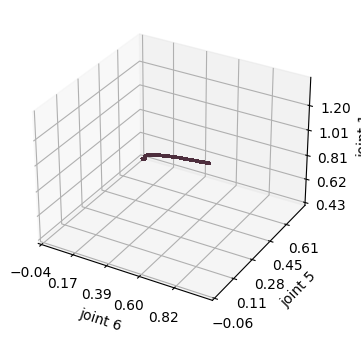

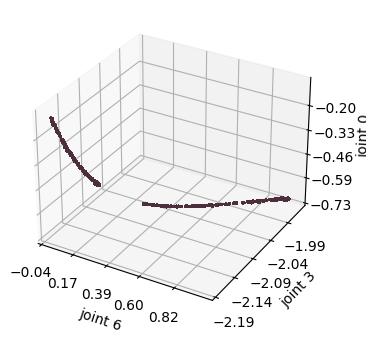

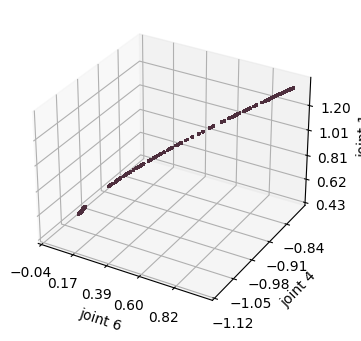

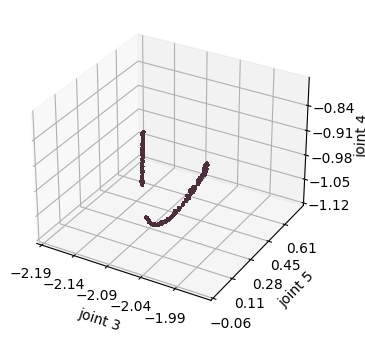

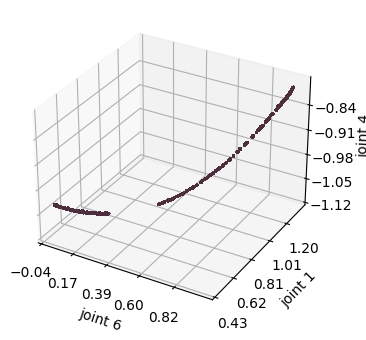

In [13]:
idx = solver.J_knn.kneighbors(df.values, n_neighbors=1, return_distance=False).flatten()
partition = solver.F[idx].flatten()
colors = np.random.rand(partition.max() + 1, 3)

desired_partition_number = np.random.randint(0, partition.max() + 1)
# filter the partition
filter_idx = partition == desired_partition_number
partition = partition[filter_idx]
df = df.loc[filter_idx]
scatter_3d_partition(df, robot_name, num_subplots, partition, subplot_columns, colors)

In [14]:
def paik_solve(solver, pose, num_solutions):
    P = pose.reshape(1, -1, pose.shape[-1])
    P = np.repeat(P, num_solutions, axis=1)
    # shape: (num_poses * num_sols, n)
    F = solver.get_reference_partition_label(P[:, 0], num_sols=num_solutions)
    # shape: (num_poses * num_sols, n_dofs)
    P = P.reshape(-1, P.shape[-1])
    J_hat = solver.generate_ik_solutions(P=P, F=F, num_sols=1)
    J_hat = J_hat.reshape(-1, J_hat.shape[-1])
    return J_hat, F

ik_solutions, partition = paik_solve(solver, P[0], num_ik_solutions)
df = pd.DataFrame(ik_solutions)
df = df.loc[:, df.std() > 1e-4]
num_dofs = df.shape[1]
print(f"Number of DOFs: {num_dofs}")
df.describe()

Number of DOFs: 7


,0,1,2,3,4,5,6
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.522057,0.062388,-0.007265,-2.198053,-0.638353,0.962475,-0.336751
std,1.728330,1.060629,1.708496,0.122628,0.472454,0.589358,0.843512
min,-2.417506,-2.253369,-2.726882,-2.352402,-1.116255,-0.094252,-3.272950
25%,-1.314341,-0.787175,-1.375262,-2.294822,-0.923902,0.373821,-0.704950
50%,1.297640,0.389811,-0.834110,-2.236994,-0.804282,1.132725,-0.306749
75%,1.876545,1.006206,1.786608,-2.106651,-0.450599,1.471128,0.190953
max,3.064910,1.861315,2.902453,-1.878623,1.121619,1.715199,2.670236


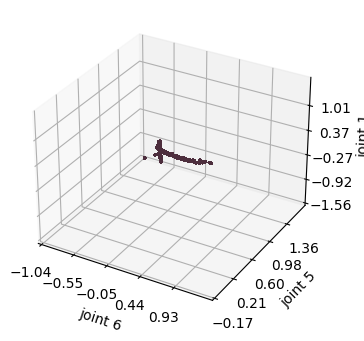

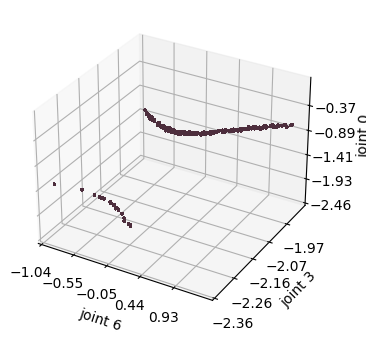

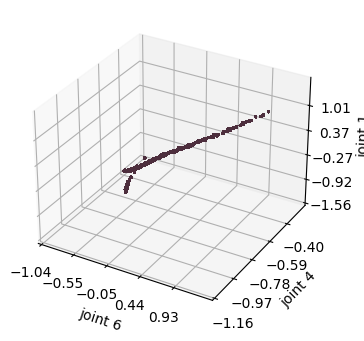

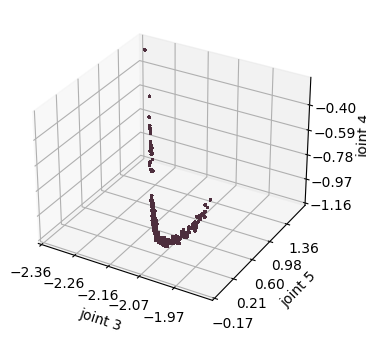

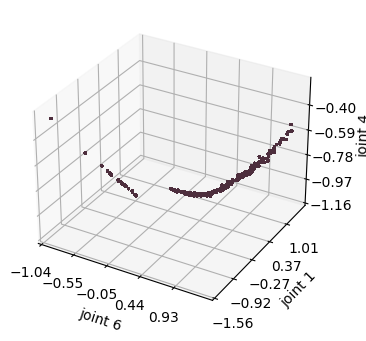

In [15]:
# scatter_3d(df, robot_name, num_subplots, subplot_columns)
# filter the partition
filter_idx = partition == desired_partition_number
partition = partition[filter_idx]
df = df.loc[filter_idx]
scatter_3d_partition(df, robot_name, num_subplots, partition, subplot_columns, colors)